In [ ]:
%load_ext autoreload
%autoreload 2

In [107]:
import torch
import transformers
from finetune_peft import get_peft_config, PEFTArguments
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType, PeftModel, PeftConfig, set_peft_model_state_dict
import peft

from peft.tuners.lora import Linear
import torch.nn.functional as F
from peft.utils.other import transpose

import time
import numpy as np

import inspect
from functools import wraps

from blora import forward
import scipy.stats as stats
Linear.forward = forward

torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [ ]:
model_path = "/home/ubuntu/llama-weights/7B/llama-7b"
tokenizer_path = model_path

torch.set_default_tensor_type(torch.cuda.HalfTensor)
model = transformers.LlamaForCausalLM.from_pretrained(model_path)

model = PeftModel.from_pretrained(model, "jondurbin/airoboros-7b-gpt4-1.2-peft", adapter_name="airoboros")
model = PeftModel.from_pretrained(model.base_model.model, "trl-lib/llama-7b-se-rl-peft", adapter_name="se-rl")

In [ ]:
tokenizer = transformers.LlamaTokenizer.from_pretrained(tokenizer_path)
batch = tokenizer(["The LLaMA language model is"] * 128, return_tensors="pt")

for name, module in model.named_modules():
    module.batch_lora_ids = ["airoboros", "se-rl"] * 64

In [ ]:
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = 1
timings=np.zeros((repetitions,1))

with torch.no_grad():
    for rep in range(repetitions):
        starter.record()
        out = model.generate(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            max_length=200,
        )
        ender.record()
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time

mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)
print(mean_syn / 1000, std_syn / 1000)

Text(0.5, 1.0, 'Generating 200 tokens with Llama-7B using Batched Lora vs Sequential on A100-80gb')

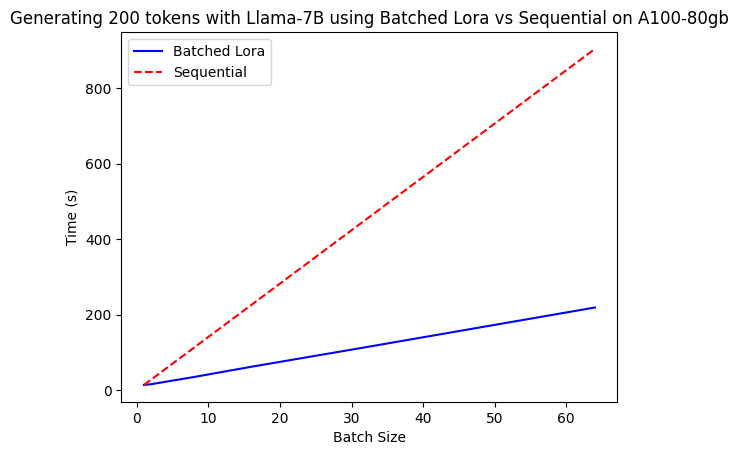

In [105]:
import matplotlib.pyplot as plt

x = np.array([1, 2, 4, 8, 16, 32, 64])
y1 = np.array([14.13, 16.05, 22.43, 35.18, 62.25, 114.11, 219.20])
y2 = 14.13 * x

plt.plot(x, y1, 'b-')
plt.plot(x, y2, 'r--')

plt.xlabel('Batch Size')
plt.ylabel('Time (s)')

plt.legend(['Batched Lora', 'Sequential'], loc='upper left')
plt.title('Generating 200 tokens with Llama-7B using Batched Lora vs Sequential on A100-80gb')

In [106]:
# get slope of y1
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y1)
print(slope)
print(intercept)

# which lib to import starts from

3.270455244818535
9.714597701149437


In [112]:
9.7 + 5 * 3.3

26.2